In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

from scipy.optimize import brute, minimize, fmin

import ROOT
from find_SN_dir import *

Welcome to JupyROOT 6.24/06


In [6]:
# Parse files

ES_param = load_pdf_parameterized("/media/linux_store/hep/data/pdf/ES_gvkm_clean_0127_pdf_param.dat", name="ES")
ES_numeric = load_pdf_numeric("/media/linux_store/hep/data/pdf/ES_gvkm_clean_0127_pdf.dat", name="ES")

directory = "/media/linux_store/hep/data/SN/" # Directory for supernova samples


ES_files = os.listdir(directory + "ES_ana")
CC_files = os.listdir(directory + "CC_ana")
SN_file_tuples = []
for ES_file in ES_files:
    CC_file = ES_file.replace('ES', 'CC')
    if(CC_file) in CC_files:
        SN_file_tuples.append((
            directory + "ES_ana/" + ES_file,
            directory + "CC_ana/" + CC_file
        ))
        continue
    ## Corresponding CC File doesnt exist
    # print(f"Corresponding CC File not found for {ES_file}.")

print(f"Found {len(SN_file_tuples)} supernova files")

Found 905 supernova files


[1.61839622 2.18959488]
[1.59547928 2.2751121 ]
Loss = 456.28275124920384


5.0694642110406605

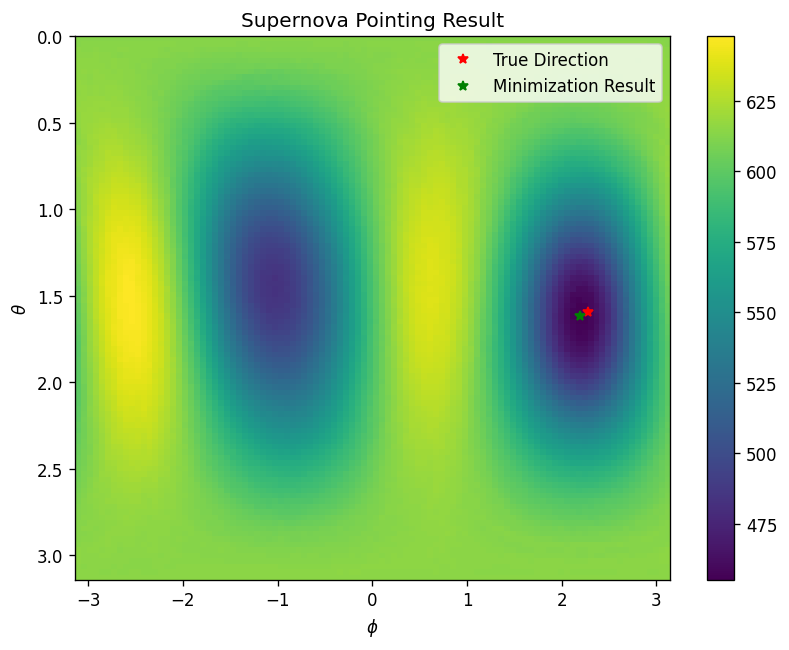

In [7]:
SN_pointer = SupernovaPointing([ES_numeric], SN_file_tuples[11], with_radio=False)
def loss_func(x):
    return SN_pointer.loss(x)
res = brute(loss_func, ([0, np.pi], [-np.pi, np.pi]), Ns=100, full_output=True, workers=6, finish=None)
# res = minimize(loss, np.array([np.pi/2, 0]), args=args, method = 'Nelder-Mead')
print(res[0])
print(SN_pointer.truth_dir)
print(f"Loss = {loss_func(SN_pointer.truth_dir)}")
details(SN_pointer, res)

## Grid Search

In [ ]:
# Brute force grid search

errors = []
from tqdm import tqdm

for SN_file_tuple in tqdm(SN_file_tuples):
    SN_pointer = SupernovaPointing([ES_numeric], [SN_file_tuple[0]])
    # SN_pointer = SupernovaPointing([ES_param], [SN_file_tuple[0]])
    def loss_func(x):
        return SN_pointer.loss(x)
    res = brute(loss_func, ([0, np.pi], [0, 2*np.pi]), Ns=25, 
                full_output=False, workers=6, finish=fmin)
    errors.append(error(SN_pointer, res))



In [ ]:
errors = np.asarray(errors)
plt.hist(errors[errors < 90])
plt.title(f"Angle between reco and truth SN direction (ES clean)\n68% Confidence Interval: {np.quantile(errors, 0.68):.2f}\nFlipped Supernovas: {errors[errors>90].size}")
plt.xlabel("Degrees")
np.quantile(errors, 0.68)

## Minimization

In [ ]:
errors = []
from tqdm import tqdm
dchisq = []
for SN_file_tuple in tqdm(SN_file_tuples):
    # SN_pointer = SupernovaPointing([ES_numeric], [SN_file_tuple[0]])
    SN_pointer = SupernovaPointing([ES_param], [SN_file_tuple[0]])
    def loss_func(x):
        return SN_pointer.loss(x)
    
#     res = minimize(loss_func, SN_pointer.high_energy_event_direction())
#     final_dir = res.x
    
    first = minimize(loss_func, np.array([np.pi/2, 0]))
    second_direction_xyz = -1 * sphere_to_xyz(first.x)
    second_direction_sphere = xyz_to_sphere(second_direction_xyz)
    second = minimize(loss_func, second_direction_sphere)
    dchisq.append(abs(second.fun - first.fun))
    final_dir = second.x if second.fun < first.fun else first.x
    errors.append(error(SN_pointer, final_dir))

plt.figure()
errors = np.asarray(errors)
plt.hist(errors)
plt.title(
    f"""Angle between reco and truth SN direction (ES + radiological)
68% Confidence Interval: {np.quantile(errors, 0.68):.2f}
Flipped Supernovas: {errors[errors>90].size}"""
)
plt.xlabel("Degrees")
np.quantile(errors, 0.68)

plt.figure()
plt.hist(dchisq)
plt.title("$\Delta \chi^2$")